In [1]:
import netCDF4 as nc
import pylab as plt
import numpy as np
from mpl_toolkits.basemap import Basemap, shiftgrid
import cf
import cfplot as cfp
import matplotlib
import numpy.ma as MA

In [2]:
data = nc.Dataset('/shared/netscratch/ptg21/UM_data/xltln/xltln_ch4.nc')
#extract variables to arrays
ch4 = data.variables['ch4'][:]*28/16.*1e9
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
box_no = data.variables['model_level_number'][:]
alt = data.variables['level_height'][:]

time = data.variables['time']
dtime = nc.num2date(time[:],time.units)

#ch4, lon = shiftgrid(180.,ch4,lon,start=False)

In [3]:
data_lbc = nc.Dataset('/shared/netscratch/ptg21/UM_data/xgywn/xgywn_pm7-9.nc')
#extract variables to arrays
ch4_lbc = data_lbc.variables['field34009'][:]*28/16.*1e9
lat_lbc = data_lbc.variables['latitude'][:]
lon_lbc = data_lbc.variables['longitude'][:]
#box_no_lbc = data_lbc.variables['model_level_number'][:]
alt_lbc = data_lbc.variables['hybrid_ht'][:]

time_lbc = data_lbc.variables['t']
dtime_lbc = nc.num2date(time_lbc[:],time_lbc.units)

#ch4_lbc, lon_lbc = shiftgrid(180.,ch4_lbc,lon_lbc,start=False)

In [4]:
#extract month from datetime object
def get_month(arr):
    months = np.empty((len(arr)))
    for i in range(len(arr)):
        months[i] = arr[i].month
    return months

ch4_xl_months = get_month(dtime)
ch4_xg_months = get_month(dtime_lbc)

In [58]:
#select month
def select_month_data(month,month_list,arr):
    month_indices = []
    jan_ch4 = []
    for i in range(len(month_list)):
        if np.int(month_list[i]) == month:
            month_indices.append(i)
            jan_ch4.append(arr[i,:,:,:])
    return(np.array(jan_ch4))

#change integer to select month
ch4_jan = select_month_data(1,ch4_xl_months,ch4)
ch4_feb = select_month_data(2,ch4_xl_months,ch4)
ch4_jan_lbc = select_month_data(1,ch4_xg_months,ch4_lbc)
ch4_feb_lbc = select_month_data(2,ch4_xg_months,ch4_lbc)
print(ch4_jan.shape)

(11, 60, 73, 96)


In [59]:
ch4_jan_mean_xl = np.mean(np.concatenate((ch4_jan,ch4_feb)), axis=(0,3))
ch4_jan_mean_xg = np.mean(np.concatenate((ch4_jan_lbc, ch4_feb_lbc)), axis=(0,3))

In [60]:
atom_mask = np.load('/home/znjs2/output/vertical_profiles/ATom_lat_lon_mask.npy')[:,:-1]

In [61]:
#add model level dimension to mask
atom_mask_3d = np.repeat(atom_mask[np.newaxis,:,:],60,axis=0)

In [62]:
time_mean_xl = np.mean(np.concatenate((ch4_jan,ch4_feb)), axis=(0))
time_mean_xg = np.mean(np.concatenate((ch4_jan_lbc,ch4_feb_lbc)), axis=(0))

In [63]:
masked_xl = MA.masked_array(time_mean_xl, atom_mask_3d)
masked_xg = MA.masked_array(time_mean_xg, atom_mask_3d)

In [64]:
#mean over lon
ch4_mean = np.mean(masked_xl,axis=2)
ch4_mean_lbc = np.mean(masked_xg, axis=2)

In [66]:
lat_bands_ch4_obs = np.load('/home/znjs2/input_data/atom_data_02_20/var_lat_binned/ch4_lat_binned_jf_custom.npy')
yvals = np.linspace(0,12000)
base_obs = lat_bands_ch4_obs[0,0]

Plot vertical profile for CH4 data with latitude bands meaned

Text(0.5, 1.0, 'CH4 Profile: model with emissions (xltln)')

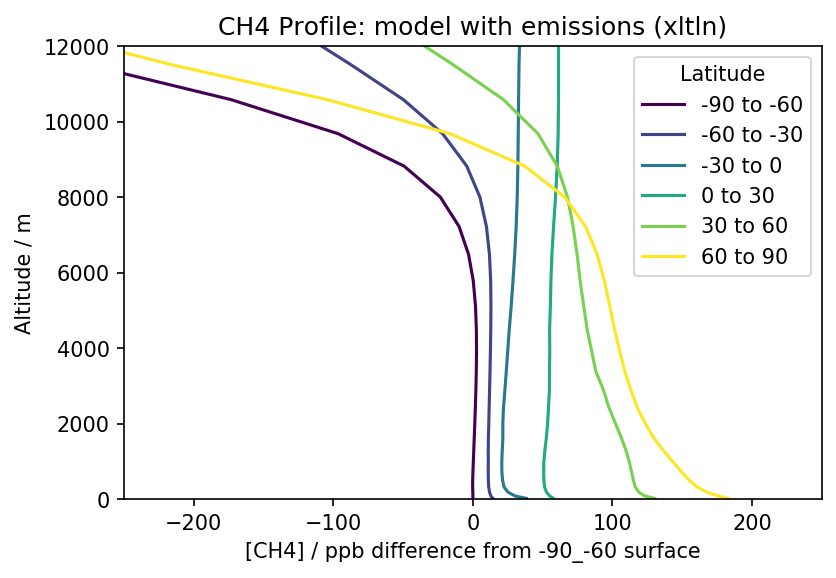

In [67]:
fig = plt.figure(dpi=150)
ax = plt.axes()
cmap = matplotlib.cm.get_cmap('viridis')

base=np.zeros(6)

for i in range(-90,90,30):
    ind1 = list(lat).index(i)
    ind2 = list(lat).index(i+30)
    lat_data = ch4_mean[:,ind1:ind2]
    lat_mean = np.mean(lat_data, axis=1)
    #print(lat_mean[0])
    ind3=np.int((i+90)/30)
    base[ind3] = lat_mean[0]
    ax.plot(lat_mean - base[0], alt, label=f'{i} to {i+30}',c=cmap((i+90)/150))
    
plt.legend(title='Latitude')
ax.set_ylim(0,12000)
ax.set_xlim(-250,250)
plt.xlabel('[CH4] / ppb difference from -90_-60 surface')
plt.ylabel('Altitude / m')
plt.title(f'CH4 Profile: model with emissions (xltln)')

Text(0.5, 1.0, 'CH4 Profile: model with LBC (xgywn)')

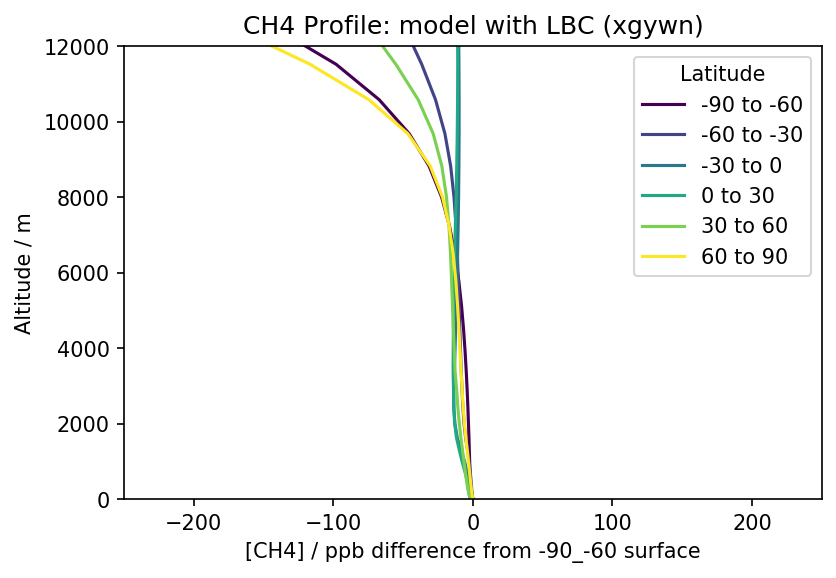

In [68]:
fig = plt.figure(dpi=150)
ax = plt.axes()
cmap = matplotlib.cm.get_cmap('viridis')

base=np.zeros(6)

for i in range(-90,90,30):
    ind1 = list(lat_lbc).index(i)
    ind2 = list(lat_lbc).index(i+30)
    lat_data = ch4_mean_lbc[:,ind1:ind2]
    lat_mean = np.mean(lat_data, axis=1)
    #print(lat_mean[0])
    ind3=np.int((i+90)/30)
    base[ind3] = lat_mean[0]
    ax.plot(lat_mean - base[0], alt_lbc, label=f'{i} to {i+30}',c=cmap((i+90)/150))
    
plt.legend(title='Latitude')
ax.set_ylim(0,12000)
ax.set_xlim(-250,250)
plt.xlabel('[CH4] / ppb difference from -90_-60 surface')
plt.ylabel('Altitude / m')
plt.title(f'CH4 Profile: model with LBC (xgywn)')

In [69]:
lat_bands_ch4 = np.empty((6,60))
base_em = np.zeros(6)

for i in range(-90,90,30):
    ind1 = list(lat).index(i)
    ind2 = list(lat).index(i+30)
    lat_data = ch4_mean[:,ind1:ind2]
    lat_mean = np.mean(lat_data, axis=1)
    ind3 = np.int((i+90)/30)
    base_em[ind3] = lat_mean[0]
    lat_bands_ch4[ind3,:] = lat_mean

print(lat_bands_ch4.shape)

(6, 60)


In [70]:
lat_bands_ch4_lbc = np.empty((6,60))
base_lbc = np.zeros(6)

for i in range(-90,90,30):
    ind1 = list(lat_lbc).index(i)
    ind2 = list(lat_lbc).index(i+30)
    lat_data = ch4_mean_lbc[:,ind1:ind2]
    lat_mean = np.mean(lat_data, axis=1)
    ind3=np.int((i+90)/30)
    base_lbc[ind3] = lat_mean[0]
    lat_bands_ch4_lbc[ind3,:] = lat_mean

In [71]:
ozone_100_xltln_JF = np.load('/shared/netscratch/znjs2/ch4_prof_data/alt_ozone_100_xltln_JF.npy')
ozone_100_xgywn_JF = np.load('/shared/netscratch/znjs2/ch4_prof_data/alt_ozone_100_xgywn_JF.npy')

ozone_100_ATom_JF = np.load('/shared/netscratch/znjs2/ch4_prof_data/alt_ozone_100_ATom_JF.npy')
ozone_100_ATom_JA = np.load('/shared/netscratch/znjs2/ch4_prof_data/alt_ozone_100_ATom_JA.npy')

Text(0.5, 0.98, 'July & August')

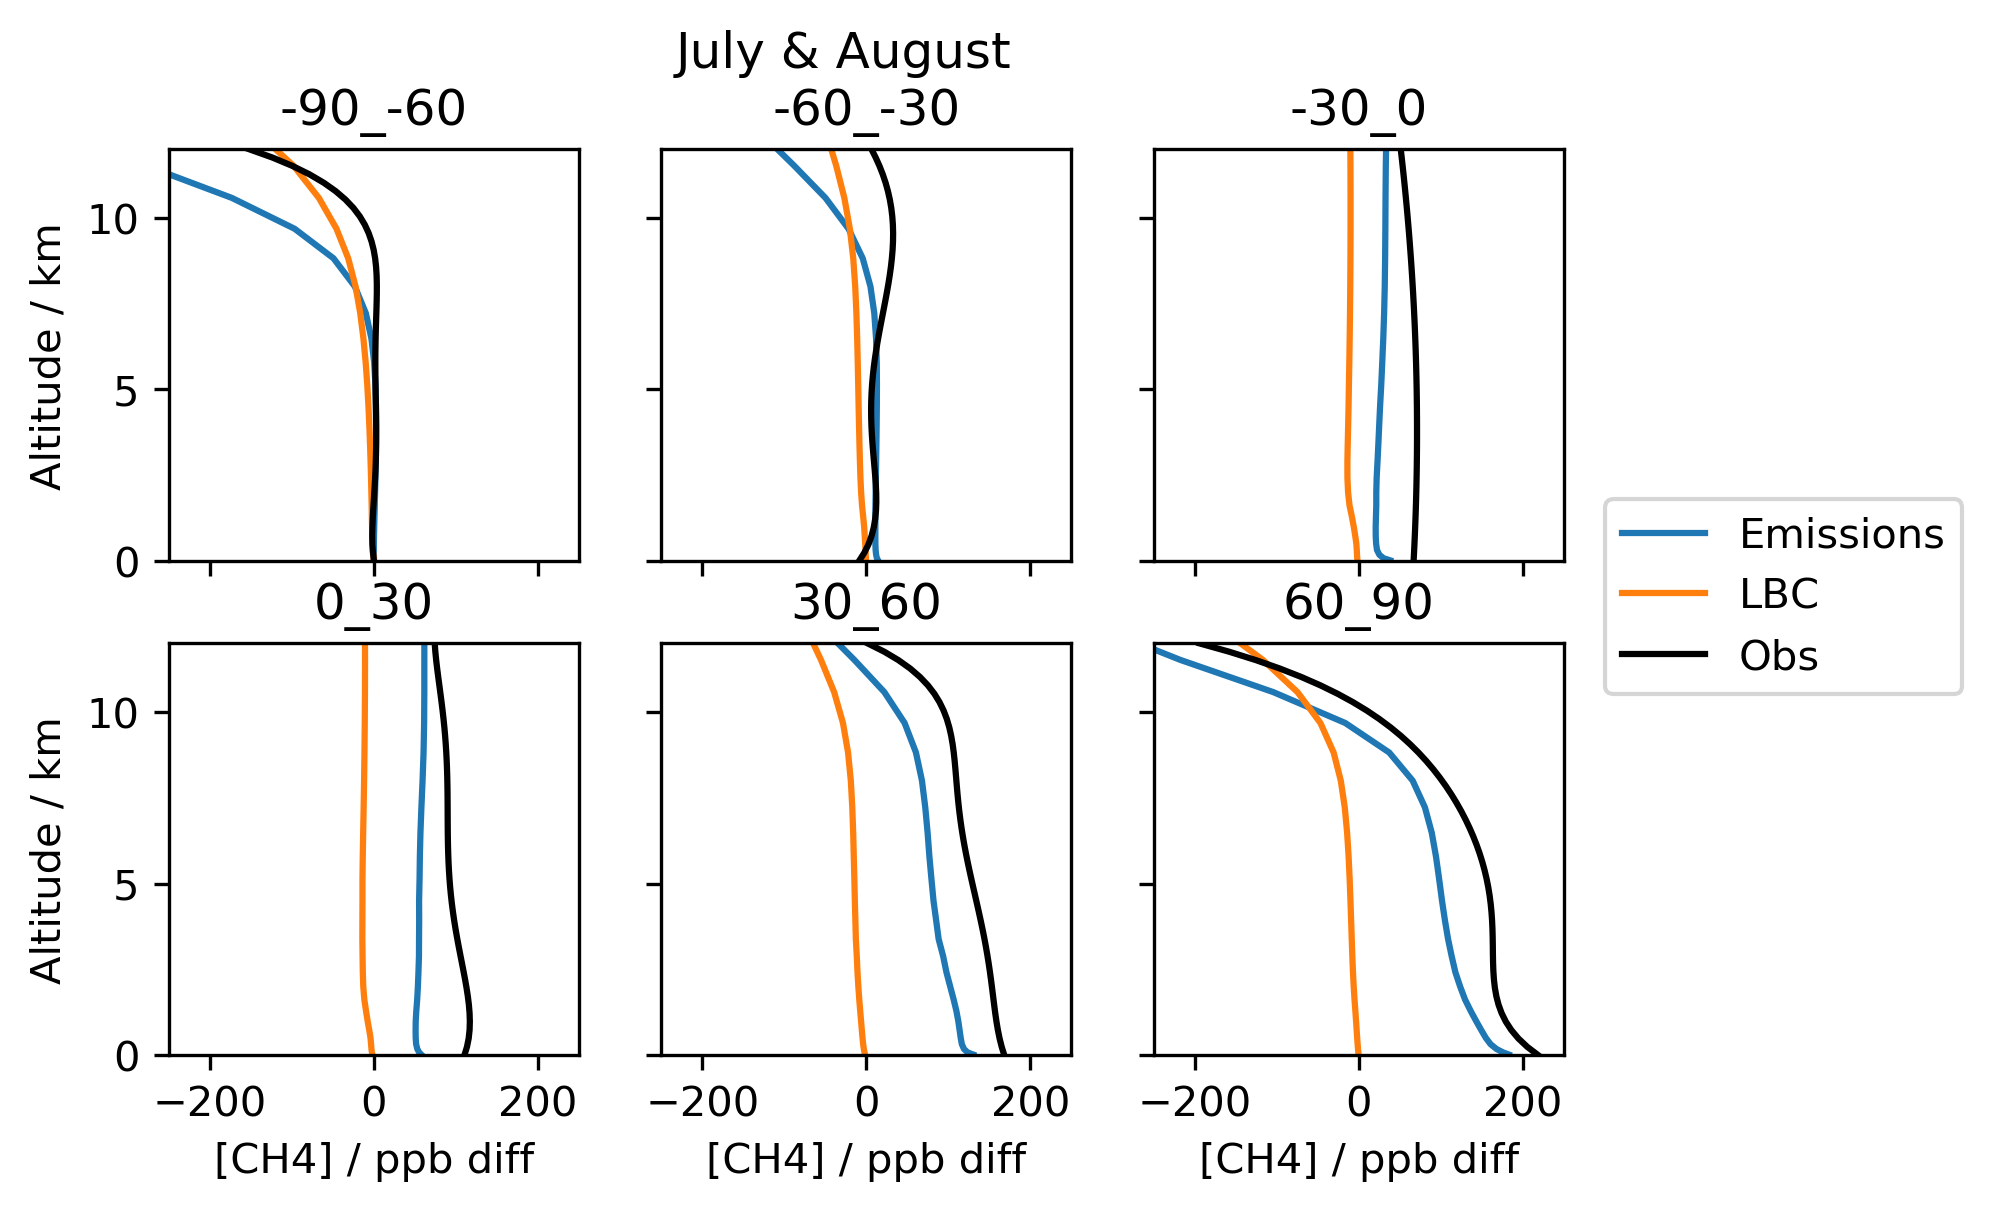

In [72]:
fig = plt.figure(dpi=300)
#ax = plt.axes()

plt_labels=["-90_-60","-60_-30","-30_0","0_30","30_60","60_90"]

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    ax.plot(lat_bands_ch4[i,:] - base_em[0], alt/1000, label=f'Emissions')
    ax.plot(lat_bands_ch4_lbc[i,:] - base_lbc[0], alt_lbc/1000, label=f'LBC')
    ax.plot(lat_bands_ch4_obs[i,:] - base_obs, yvals/1000, c ='k' ,label=f'Obs')
    #ax.plot([-250, 250], [ozone_100_xgywn_JF[i], ozone_100_xgywn_JF[i]], 'orange',linestyle=':')
    #ax.plot([-250, 250], [ozone_100_xltln_JF[i], ozone_100_xltln_JF[i]], 'cornflowerblue',linestyle=':')
    ax.set_ylim(0,12)
    ax.set_xlim(-250,250)
    plt.xlabel('[CH4] / ppb diff')
    plt.ylabel('Altitude / km')
    plt.title(f'{plt_labels[i]}')
    if i == 5:
        plt.legend(bbox_to_anchor=(1.05,1.4))

for ax in fig.get_axes():
    ax.label_outer()

fig.suptitle('July & August')
#for legend for all lines in all subplots
#fig.legend(bbox_to_anchor=(1.1,1))

Text(0.5, 0.98, 'January & February')

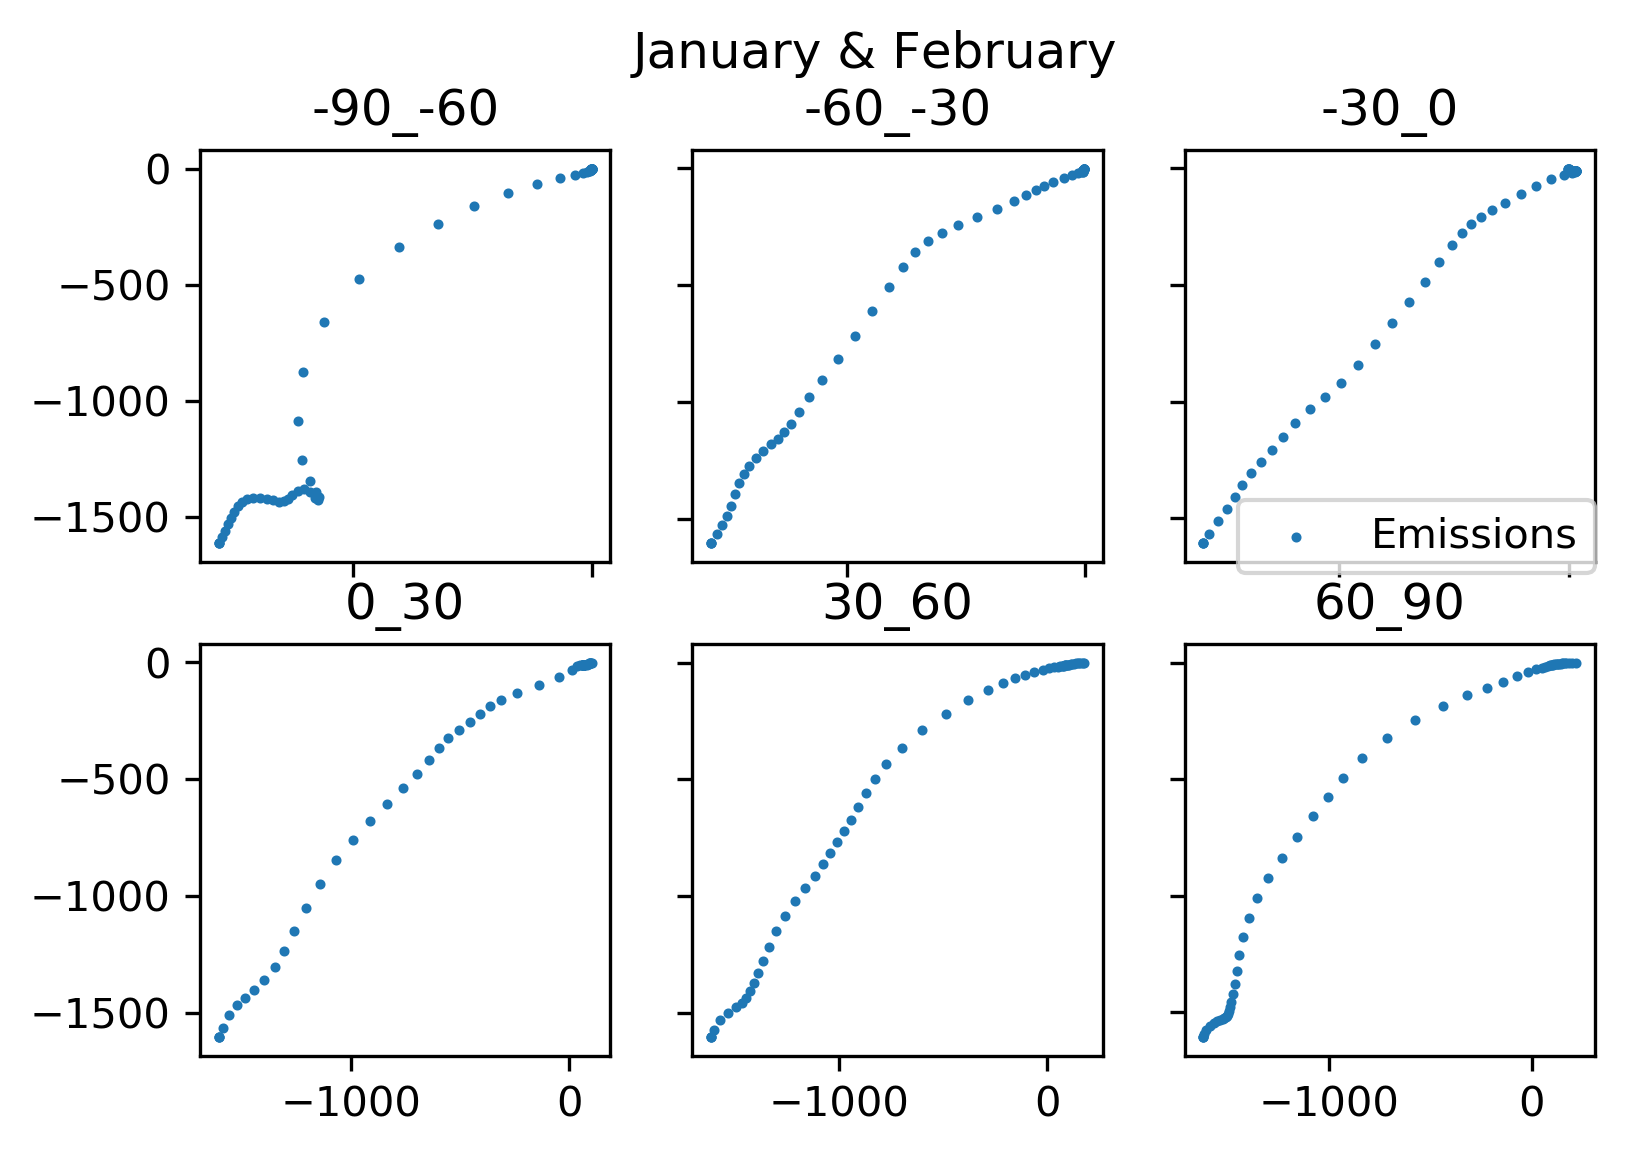

In [55]:
fig = plt.figure(dpi=300)
#ax = plt.axes()

plt_labels=["-90_-60","-60_-30","-30_0","0_30","30_60","60_90"]

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    ax.scatter(lat_bands_ch4[i,:] - base_em[0], lat_bands_ch4_lbc[i,:] - base_lbc[0], label=f'Emissions',s=2)
    #ax.plot(lat_bands_ch4_lbc[i,:] - base_lbc[0], alt_lbc/1000, label=f'LBC')
    #ax.plot(lat_bands_ch4_obs[i,:] - base_obs, yvals/1000, c ='k' ,label=f'Obs')
    #ax.plot([-250, 250], [ozone_100_xgywn_JF[i], ozone_100_xgywn_JF[i]], 'orange',linestyle=':')
    #ax.plot([-250, 250], [ozone_100_xltln_JF[i], ozone_100_xltln_JF[i]], 'cornflowerblue',linestyle=':')
    #ax.set_ylim(0,12)
    #ax.set_xlim(-250,250)
    #plt.xlabel('[CH4] / ppb diff')
    #plt.ylabel('Altitude / km')
    plt.title(f'{plt_labels[i]}')
    if i == 5:
        plt.legend(bbox_to_anchor=(1.05,1.4))

for ax in fig.get_axes():
    ax.label_outer()

fig.suptitle('January & February')
#for legend for all lines in all subplots
#fig.legend(bbox_to_anchor=(1.1,1))

Text(0.5, 0.98, 'January & February')

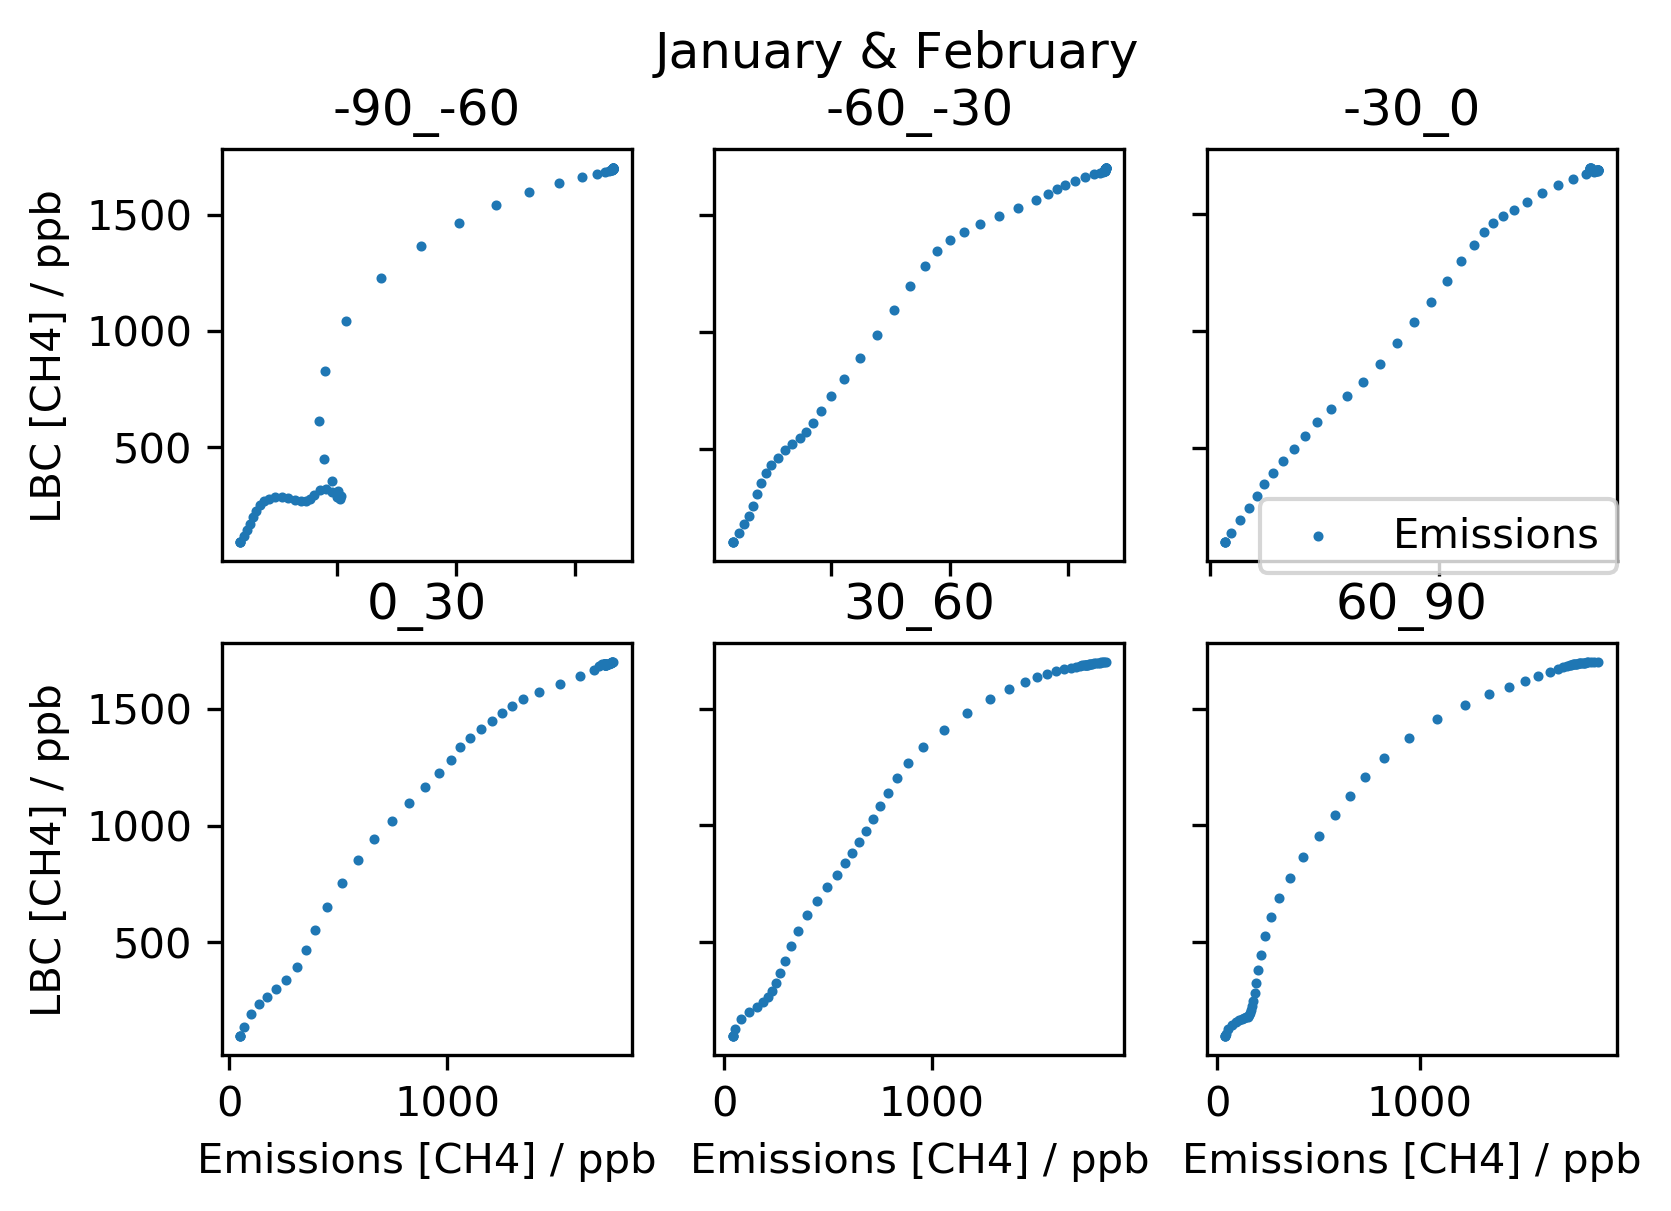

In [56]:
fig = plt.figure(dpi=300)
#ax = plt.axes()

plt_labels=["-90_-60","-60_-30","-30_0","0_30","30_60","60_90"]

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    ax.scatter(lat_bands_ch4[i,:], lat_bands_ch4_lbc[i,:], label=f'Emissions',s=2)
    #ax.plot(lat_bands_ch4_lbc[i,:] - base_lbc[0], alt_lbc/1000, label=f'LBC')
    #ax.plot(lat_bands_ch4_obs[i,:] - base_obs, yvals/1000, c ='k' ,label=f'Obs')
    #ax.plot([-250, 250], [ozone_100_xgywn_JF[i], ozone_100_xgywn_JF[i]], 'orange',linestyle=':')
    #ax.plot([-250, 250], [ozone_100_xltln_JF[i], ozone_100_xltln_JF[i]], 'cornflowerblue',linestyle=':')
    #ax.set_ylim(0,12)
    #ax.set_xlim(-250,250)
    plt.xlabel('Emissions [CH4] / ppb')
    plt.ylabel('LBC [CH4] / ppb')
    plt.title(f'{plt_labels[i]}')
    if i == 5:
        plt.legend(bbox_to_anchor=(1.05,1.4))

for ax in fig.get_axes():
    ax.label_outer()

fig.suptitle('January & February')
#for legend for all lines in all subplots
#fig.legend(bbox_to_anchor=(1.1,1))

Text(0.5, 0.98, 'July & August')

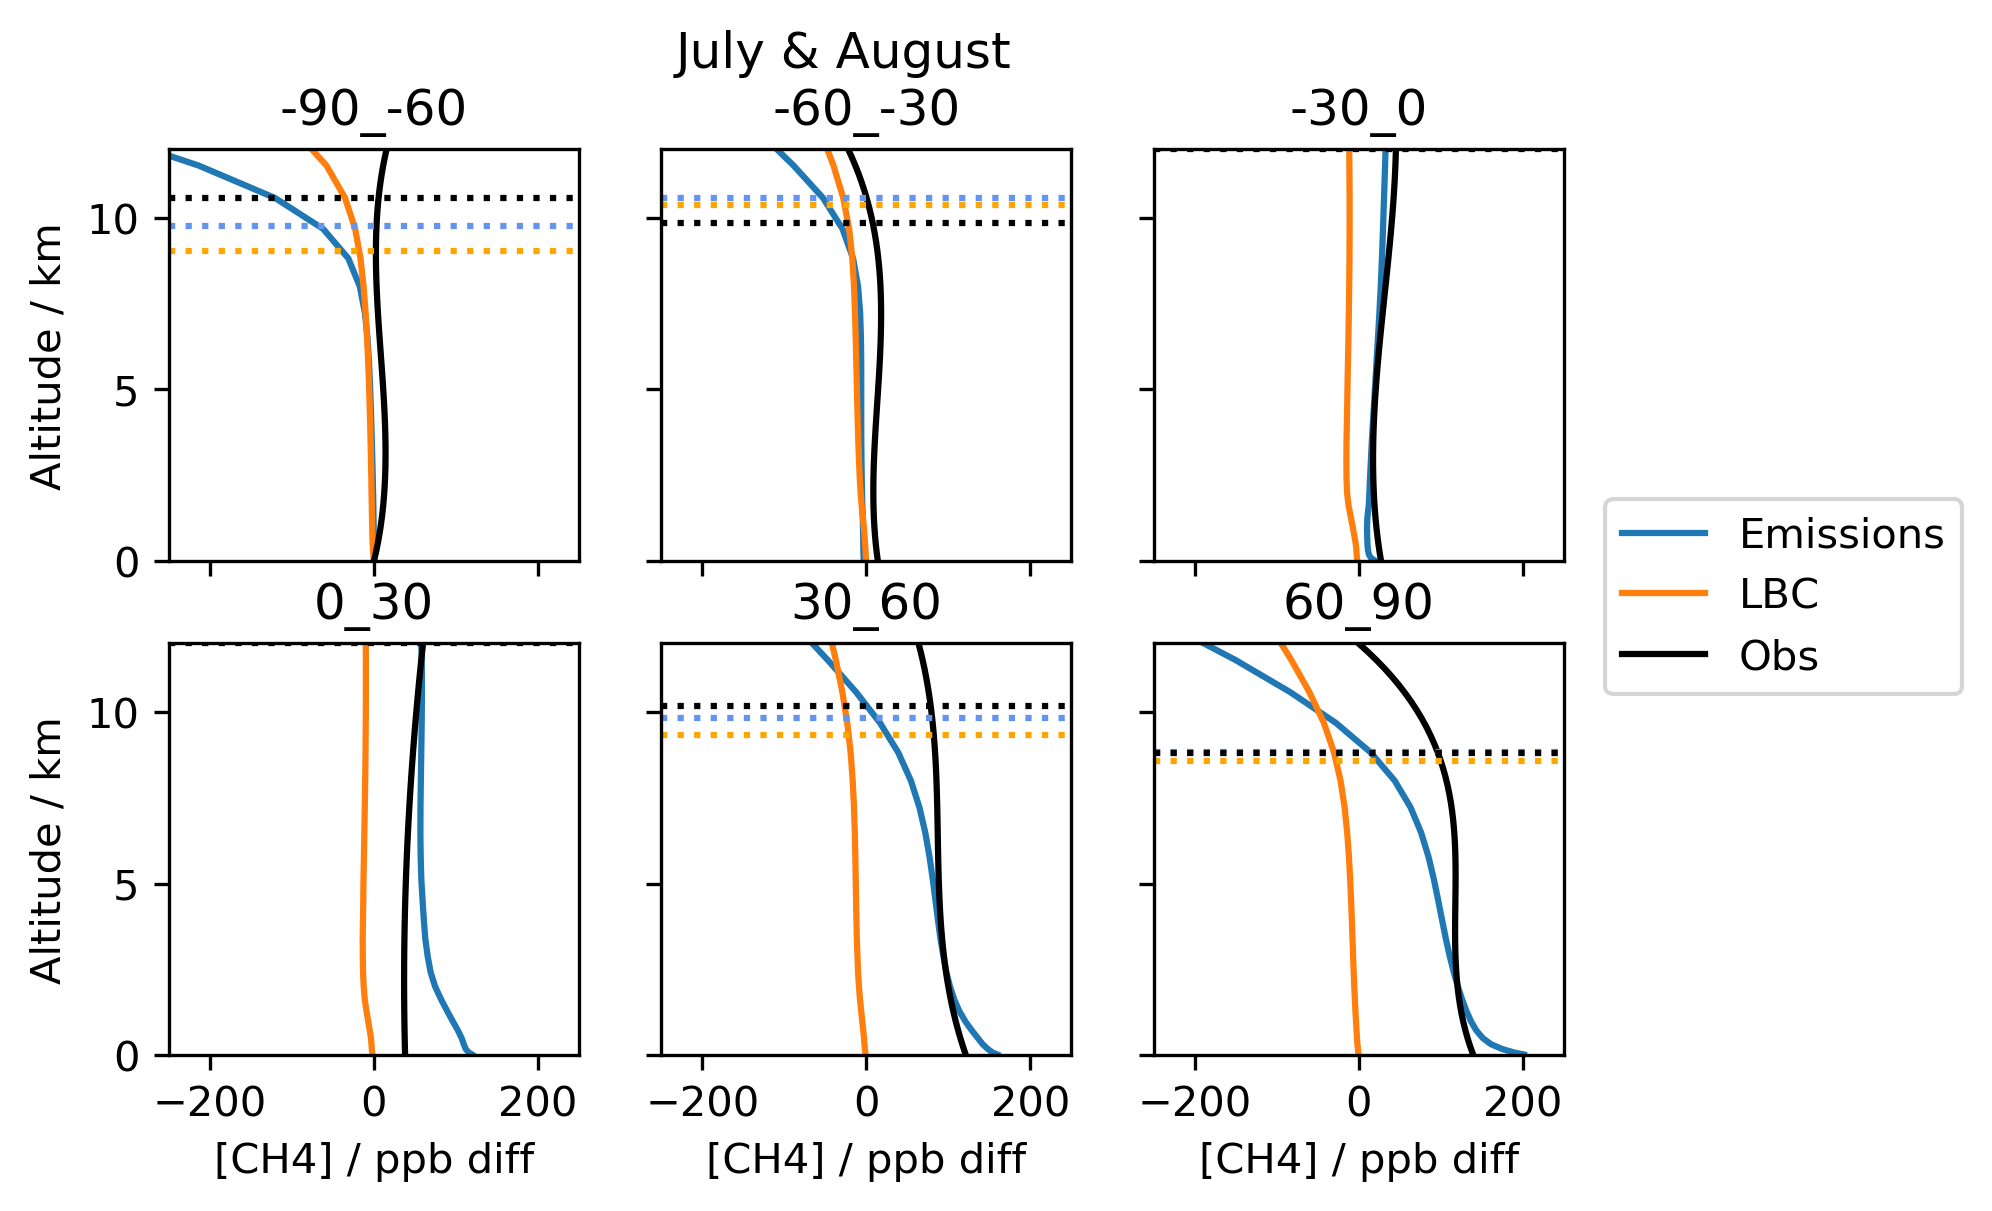

In [60]:
fig = plt.figure(dpi=300)
#ax = plt.axes()

plt_labels=["-90_-60","-60_-30","-30_0","0_30","30_60","60_90"]

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    ax.plot(lat_bands_ch4[i,:] - base_em[0], alt/1000, label=f'Emissions')
    ax.plot(lat_bands_ch4_lbc[i,:] - base_lbc[0], alt_lbc/1000, label=f'LBC')
    ax.plot(lat_bands_ch4_obs[i,:] - base_obs, yvals/1000, c ='k' ,label=f'Obs')
    ax.plot([-250, 250], [ozone_100_xgywn_JF[i], ozone_100_xgywn_JF[i]], 'orange',linestyle=':')
    ax.plot([-250, 250], [ozone_100_xltln_JF[i], ozone_100_xltln_JF[i]], 'cornflowerblue',linestyle=':')
    ax.plot([-250, 250], [ozone_100_ATom_JA[i], ozone_100_ATom_JA[i]], 'k',linestyle=':') 
    ax.set_ylim(0,12)
    ax.set_xlim(-250,250)
    plt.xlabel('[CH4] / ppb diff')
    plt.ylabel('Altitude / km')
    plt.title(f'{plt_labels[i]}')
    if i == 5:
        plt.legend(bbox_to_anchor=(1.05,1.4))

for ax in fig.get_axes():
    ax.label_outer()

fig.suptitle('July & August')
#for legend for all lines in all subplots
#fig.legend(bbox_to_anchor=(1.1,1))